In [4]:
# ------------------------------------------------------------
# Safe one-shot install for Python 3.7 (no puccinialin error)
# ------------------------------------------------------------
!pip install -U \
    "safetensors<=0.3.3" \
    "transformers<4.30" \
    "sentence-transformers==2.2.2" \
    "skillsnetwork" \
    "yellowbrick" \
    "seaborn>=0.12" \
    "texthero" \
    "pyclustering" \
    "nltk" \
    "nmslib"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 111.2 MB/s eta 0:00:0000:01
  Using cached sentence-transformers-2.2.2.tar.gz (85 kB)
  Preparing metadata (setup.py) ... done
  Using cached yellowbrick-1.5-py3-none-any.whl (282 kB)
  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
  Using cached texthero-1.1.0-py3-none-any.whl (24 kB)
  Using cached pyclustering-0.10.1.2.tar.gz (2.6 MB)
  Preparing metadata (setup.py) ... done
  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
  Using cached nmslib-2.1.1-cp37-cp37m-manylinux2010_x86_64.whl (13.5 MB)
  Using cached sentencepiece-0.2.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
  Using cached huggingface_hub-0.16.4-py3-none-any.whl (268 kB)
  Using cached filelock-3.12.2-py3-none-any.whl (10 kB)
  Using cached regex-2024.4.16-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (761 kB)
  Using cached tokenizers-0.1

In [6]:
import os
os.environ["NMSLIB_NO_WARNING"] = "1"      # <-- suppress the SSE/AVX message

import nmslib
from nltk.stem import PorterStemmer
import string
import re
import nltk
import skillsnetwork
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans

# Optional: suppress other warnings
import warnings
warnings.filterwarnings('ignore')

sns.set_context('notebook')
sns.set_style('white')

In [7]:
df1 = pd.read_csv('course-catalog.csv')
df1.head(2)

Year  Term YearTerm Subject  Number                          Name  \
0  2022  Fall  2022-fa     AAS     100  Intro Asian American Studies   
1  2022  Fall  2022-fa     AAS     100  Intro Asian American Studies   

                                         Description Credit Hours  \
0  Interdisciplinary introduction to the basic co...     3 hours.   
1  Interdisciplinary introduction to the basic co...     3 hours.   

  Section Info                                  Degree Attributes  ...  \
0          NaN  Social & Beh Sci - Soc Sci, and Cultural Studi...  ...   
1          NaN  Social & Beh Sci - Soc Sci, and Cultural Studi...  ...   

  Section Status  Enrollment Status                   Type Type Code  \
0              A               Open  Discussion/Recitation       DIS   
1              A             Closed  Discussion/Recitation       DIS   

  Start Time  End Time Days of Week Room        Building      Instructors  
0   09:00 AM  09:50 AM            F  313  Davenport Hall  Lee, S;Zheng, R  
1   10:00 AM  10:50 AM            F  313  Davenport Hall  Lee, S;Zheng, R  

[2 rows x 27 columns]

In [ ]:
df1 = pd.read_csv('course-catalog.csv')
print('==> List of all columns: \n\n',list(df1),'\n')

# sort data by names and subset data
df1 = df1.sort_values(by='Name')

# drop the duplicated data point in the description
df1 = df1.drop_duplicates(subset='Description', keep="first")

# select columns the we are interested
df1 = df1[['Subject','Name','Description']]
df1.head()

==> List of all columns: 

 ['Year', 'Term', 'YearTerm', 'Subject', 'Number', 'Name', 'Description', 'Credit Hours', 'Section Info', 'Degree Attributes', 'Schedule Information', 'CRN', 'Section', 'Status Code', 'Part of Term', 'Section Title', 'Section Credit Hours', 'Section Status', 'Enrollment Status', 'Type', 'Type Code', 'Start Time', 'End Time', 'Days of Week', 'Room', 'Building', 'Instructors'] 



Subject                              Name  \
5926      GER                    1920s to Today   
6324     HIST  19thC Romanticism &amp; Politics   
11832    SPAN        20th-21stC Spanish Studies   
5934      GER              20thC German Studies   
6309     HIST         20thC World to Midcentury   

                                             Description  
5926   Literary, thematic, cultural, and bibliographi...  
6324   Among the topics of this course will be Romant...  
11832  Examines the cultural production of 20th and 2...  
5934   Seminar in selected genres, themes, or authors...  
6309   Economic, social, political, and cultural deve...

In [9]:
# creating the main dataset
data = df1.reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4412 entries, 0 to 4411
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Subject      4412 non-null   object
 1   Name         4412 non-null   object
 2   Description  4411 non-null   object
dtypes: object(3)
memory usage: 103.5+ KB


show then number of unique ```Subject``` in the data


In [10]:
# show the all subject in the data
len(data['Subject'].unique())

190

In [11]:
# counting the datapoints for each group of subject 
keep=data.groupby('Subject').count().sort_values(by='Name',ascending=False)
print(' ==> list of Subject and their counts:', keep)

# keep only first 20 most frequent
keep=keep[:20].index
print('\n ==> List of Subject to keep: \n\n', keep)

 ==> list of Subject and their counts:          Name  Description
Subject                   
MUSC      138          138
MUS       107          107
ECE       100          100
IS         95           95
CS         87           87
...       ...          ...
GMC         1            1
CZCH        1            1
BASQ        1            1
CIC         1            1
HRD         1            1

[190 rows x 2 columns]

 ==> List of Subject to keep: 

 Index(['MUSC', 'MUS', 'ECE', 'IS', 'CS', 'THEA', 'BADM', 'CLE', 'PSYC', 'MATH',
       'FIN', 'ENGL', 'CHEM', 'FSHN', 'CEE', 'CHLH', 'KIN', 'PS', 'RST',
       'ANTH'],
      dtype='object', name='Subject')


In [12]:

data = data[data['Subject'].isin(keep)]
data = data.reset_index(drop=True)
data.shape

(1476, 3)

### Preprocessing Text for Clustering


In [13]:
# selecting the column that has text
text = data['Description']

# removing null values
text = text[~pd.isnull(text)] #removing missing values

# preprocessing
text=text.tolist()
text[:3]

['Isomorphism theorems for groups. Group actions. Composition series. Jordan-Holder theorem. Solvable and nilpotent groups. Field extensions. Algebraic and transcendental extensions. Algebraic closures. Fundamental theorem of Galois theory, and applications. Modules over commutative rings. Structure of finitely generated modules over a principal ideal domain. Applications to finite Abelian groups and matrix canonical forms. Prerequisite: MATH 417 and MATH 418.',
 'Rigorous proof-oriented course in linear algebra. Topics include determinants, vector spaces over fields, linear transformations, inner product spaces, eigenvectors and eigenvalues, Hermitian matrices, Jordan Normal Form. 3 or 4 undergraduate hours. 3 or 4 graduate hours. Credit is not given for both MATH 416 and either ASRM 406 or MATH 415. 4 hours of credit requires approval of the instructor and department with completion of additional work of substance. Prerequisite: MATH 241 or consent of instructor; MATH 347 is recommen

In [14]:
# make it lower case
text = [t.lower() for t in text]
text[:3]

# Strip all punctuation from each article
# This uses str.translate to map all punctuation to the empty string
table = str.maketrans('', '', string.punctuation)
text = [t.translate(table) for t in text]

# Convert all numbers in the article to the word 'num' using regular expressions
text = [re.sub(r'\d+', 'num', t) for t in text]
# Print the first article as a running example
text[:2]

['isomorphism theorems for groups group actions composition series jordanholder theorem solvable and nilpotent groups field extensions algebraic and transcendental extensions algebraic closures fundamental theorem of galois theory and applications modules over commutative rings structure of finitely generated modules over a principal ideal domain applications to finite abelian groups and matrix canonical forms prerequisite math num and math num',
 'rigorous prooforiented course in linear algebra topics include determinants vector spaces over fields linear transformations inner product spaces eigenvectors and eigenvalues hermitian matrices jordan normal form num or num undergraduate hours num or num graduate hours credit is not given for both math num and either asrm num or math num num hours of credit requires approval of the instructor and department with completion of additional work of substance prerequisite math num or consent of instructor math num is recommended']

In [15]:
# stemming using PorterStemmer
#from nltk.stem import PorterStemmer

# creating stemmer model and fit evey sentence to it
stemmer = PorterStemmer()
text_stem = [stemmer.stem(t) for t in text]

In [16]:
# Import nltk, and WordNetLemmatizer
#import nltk
#from nltk.stem import WordNetLemmatizer

# for lemmatization, you need to download "wordnet" repository which contains family of words
nltk.download("wordnet")

# create lemmatizer and apply it for every sentence in the text
lem = nltk.stem.wordnet.WordNetLemmatizer()
text_lem = [lem.lemmatize(t) for t in text_stem]
text_lem[:3]

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/jupyterlab/nltk_data...


['isomorphism theorems for groups group actions composition series jordanholder theorem solvable and nilpotent groups field extensions algebraic and transcendental extensions algebraic closures fundamental theorem of galois theory and applications modules over commutative rings structure of finitely generated modules over a principal ideal domain applications to finite abelian groups and matrix canonical forms prerequisite math num and math num',
 'rigorous prooforiented course in linear algebra topics include determinants vector spaces over fields linear transformations inner product spaces eigenvectors and eigenvalues hermitian matrices jordan normal form num or num undergraduate hours num or num graduate hours credit is not given for both math num and either asrm num or math num num hours of credit requires approval of the instructor and department with completion of additional work of substance prerequisite math num or consent of instructor math num is recommend',
 'lectures and di

In [17]:
from sentence_transformers import SentenceTransformer
from sentence_transformers import util
model_SBERT = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
# this method encode the sentences into numpy vectors which can be used for clustering task
embeddings = model_SBERT.encode(text_lem, convert_to_numpy=True,show_progress_bar=True,batch_size=100) # By default, convert_to_numpy = True
embeddings.shape

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

(1476, 384)

In [ ]:
print(embeddings[0][:50])

[-0.05439125 -0.05611385 -0.0076612   0.02458502 -0.05390879  0.05349707
  0.03884916 -0.05550802  0.0262494  -0.06594925  0.07264095  0.0174734
 -0.02111336 -0.05083277  0.01680724  0.03915072 -0.07581127  0.05780488
 -0.04076366 -0.02741103  0.02231018  0.01286337 -0.04854944  0.04025704
 -0.04496966 -0.04309182 -0.02955399  0.00504693  0.0474054  -0.040225
 -0.08825973  0.05135298  0.07899446  0.01752577 -0.09523842  0.15355127
 -0.01529991  0.03532825 -0.05817359 -0.03264988  0.02318592 -0.00398333
  0.00623468 -0.04402874  0.00563044 -0.02827858  0.03140191 -0.01629698
 -0.04327277  0.01849664]


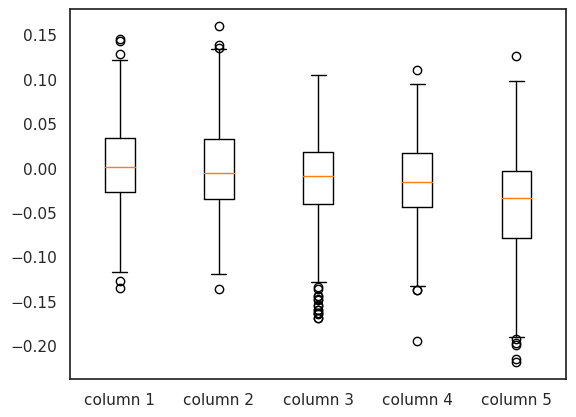

In [20]:
# lets simply plot 5 first columns (out of 384 columns) to visualize the distribution
# Create a figure and axes object
fig, ax = plt.subplots()

# Create the box plots
bp1 = ax.boxplot(embeddings[:,0], positions=[1], widths=0.3)
bp2 = ax.boxplot(embeddings[:,1], positions=[2], widths=0.3)
bp3 = ax.boxplot(embeddings[:,2], positions=[3], widths=0.3)
bp4 = ax.boxplot(embeddings[:,3], positions=[4], widths=0.3)
bp4 = ax.boxplot(embeddings[:,4], positions=[5], widths=0.3)

# Set the x-axis labels
ax.set_xticklabels(['column 1', 'column 2', 'column 3','column 4','column 5'])

# Show the plot
plt.show()

--------
## Choosing the Number of Clusters (k) for K-means Clustering


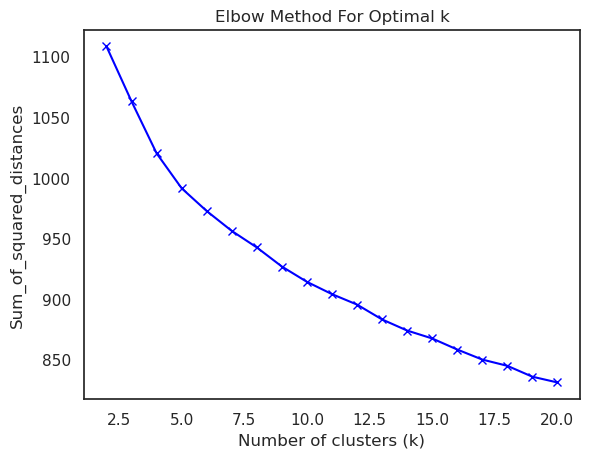

In [21]:
# simple elbow method

Sum_of_squared_distances = []

# range of possible k from 2 to 20
K = range(2,21)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(embeddings)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


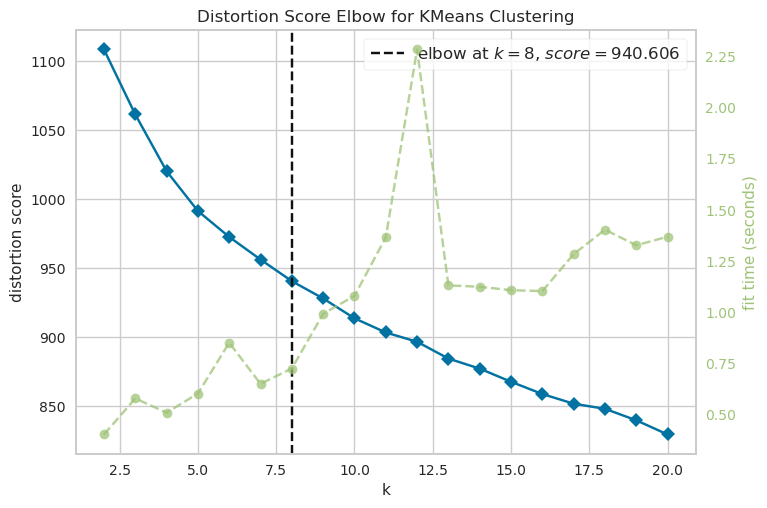

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [22]:
# Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,21), timings= True)
visualizer.fit(embeddings)    
visualizer.show()        

In [23]:
# we going append the best number of k into the list to reach our final desicion
optimal_Ks=[]

### Silhouette technique


==> Silhouetter Score: 0.051
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(n_clusters=2, random_state=11))

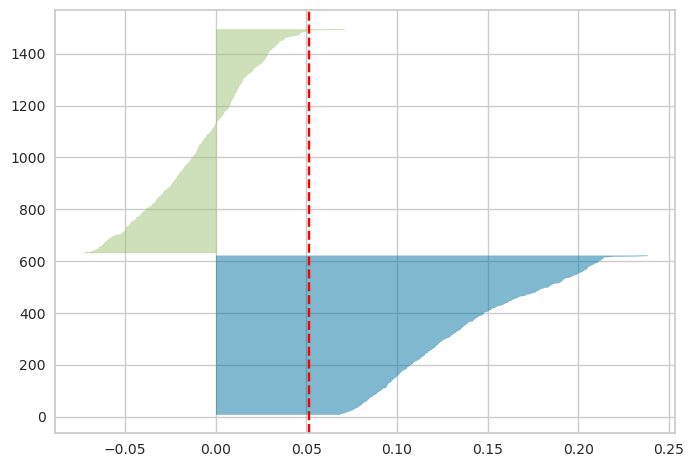

In [24]:
# Trying only two clusters with Silhouette

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

# Instantiate the KMeans models
km = KMeans(n_clusters=2, random_state=11)

# Fit the KMeans model
km.fit_predict(embeddings)

# Calculate Silhoutte Score
score = silhouette_score(embeddings, km.labels_, metric='euclidean')

# Print the score
print('==> Silhouetter Score: %.3f' % score)
SilhouetteVisualizer(km, colors='yellowbrick').fit(embeddings)

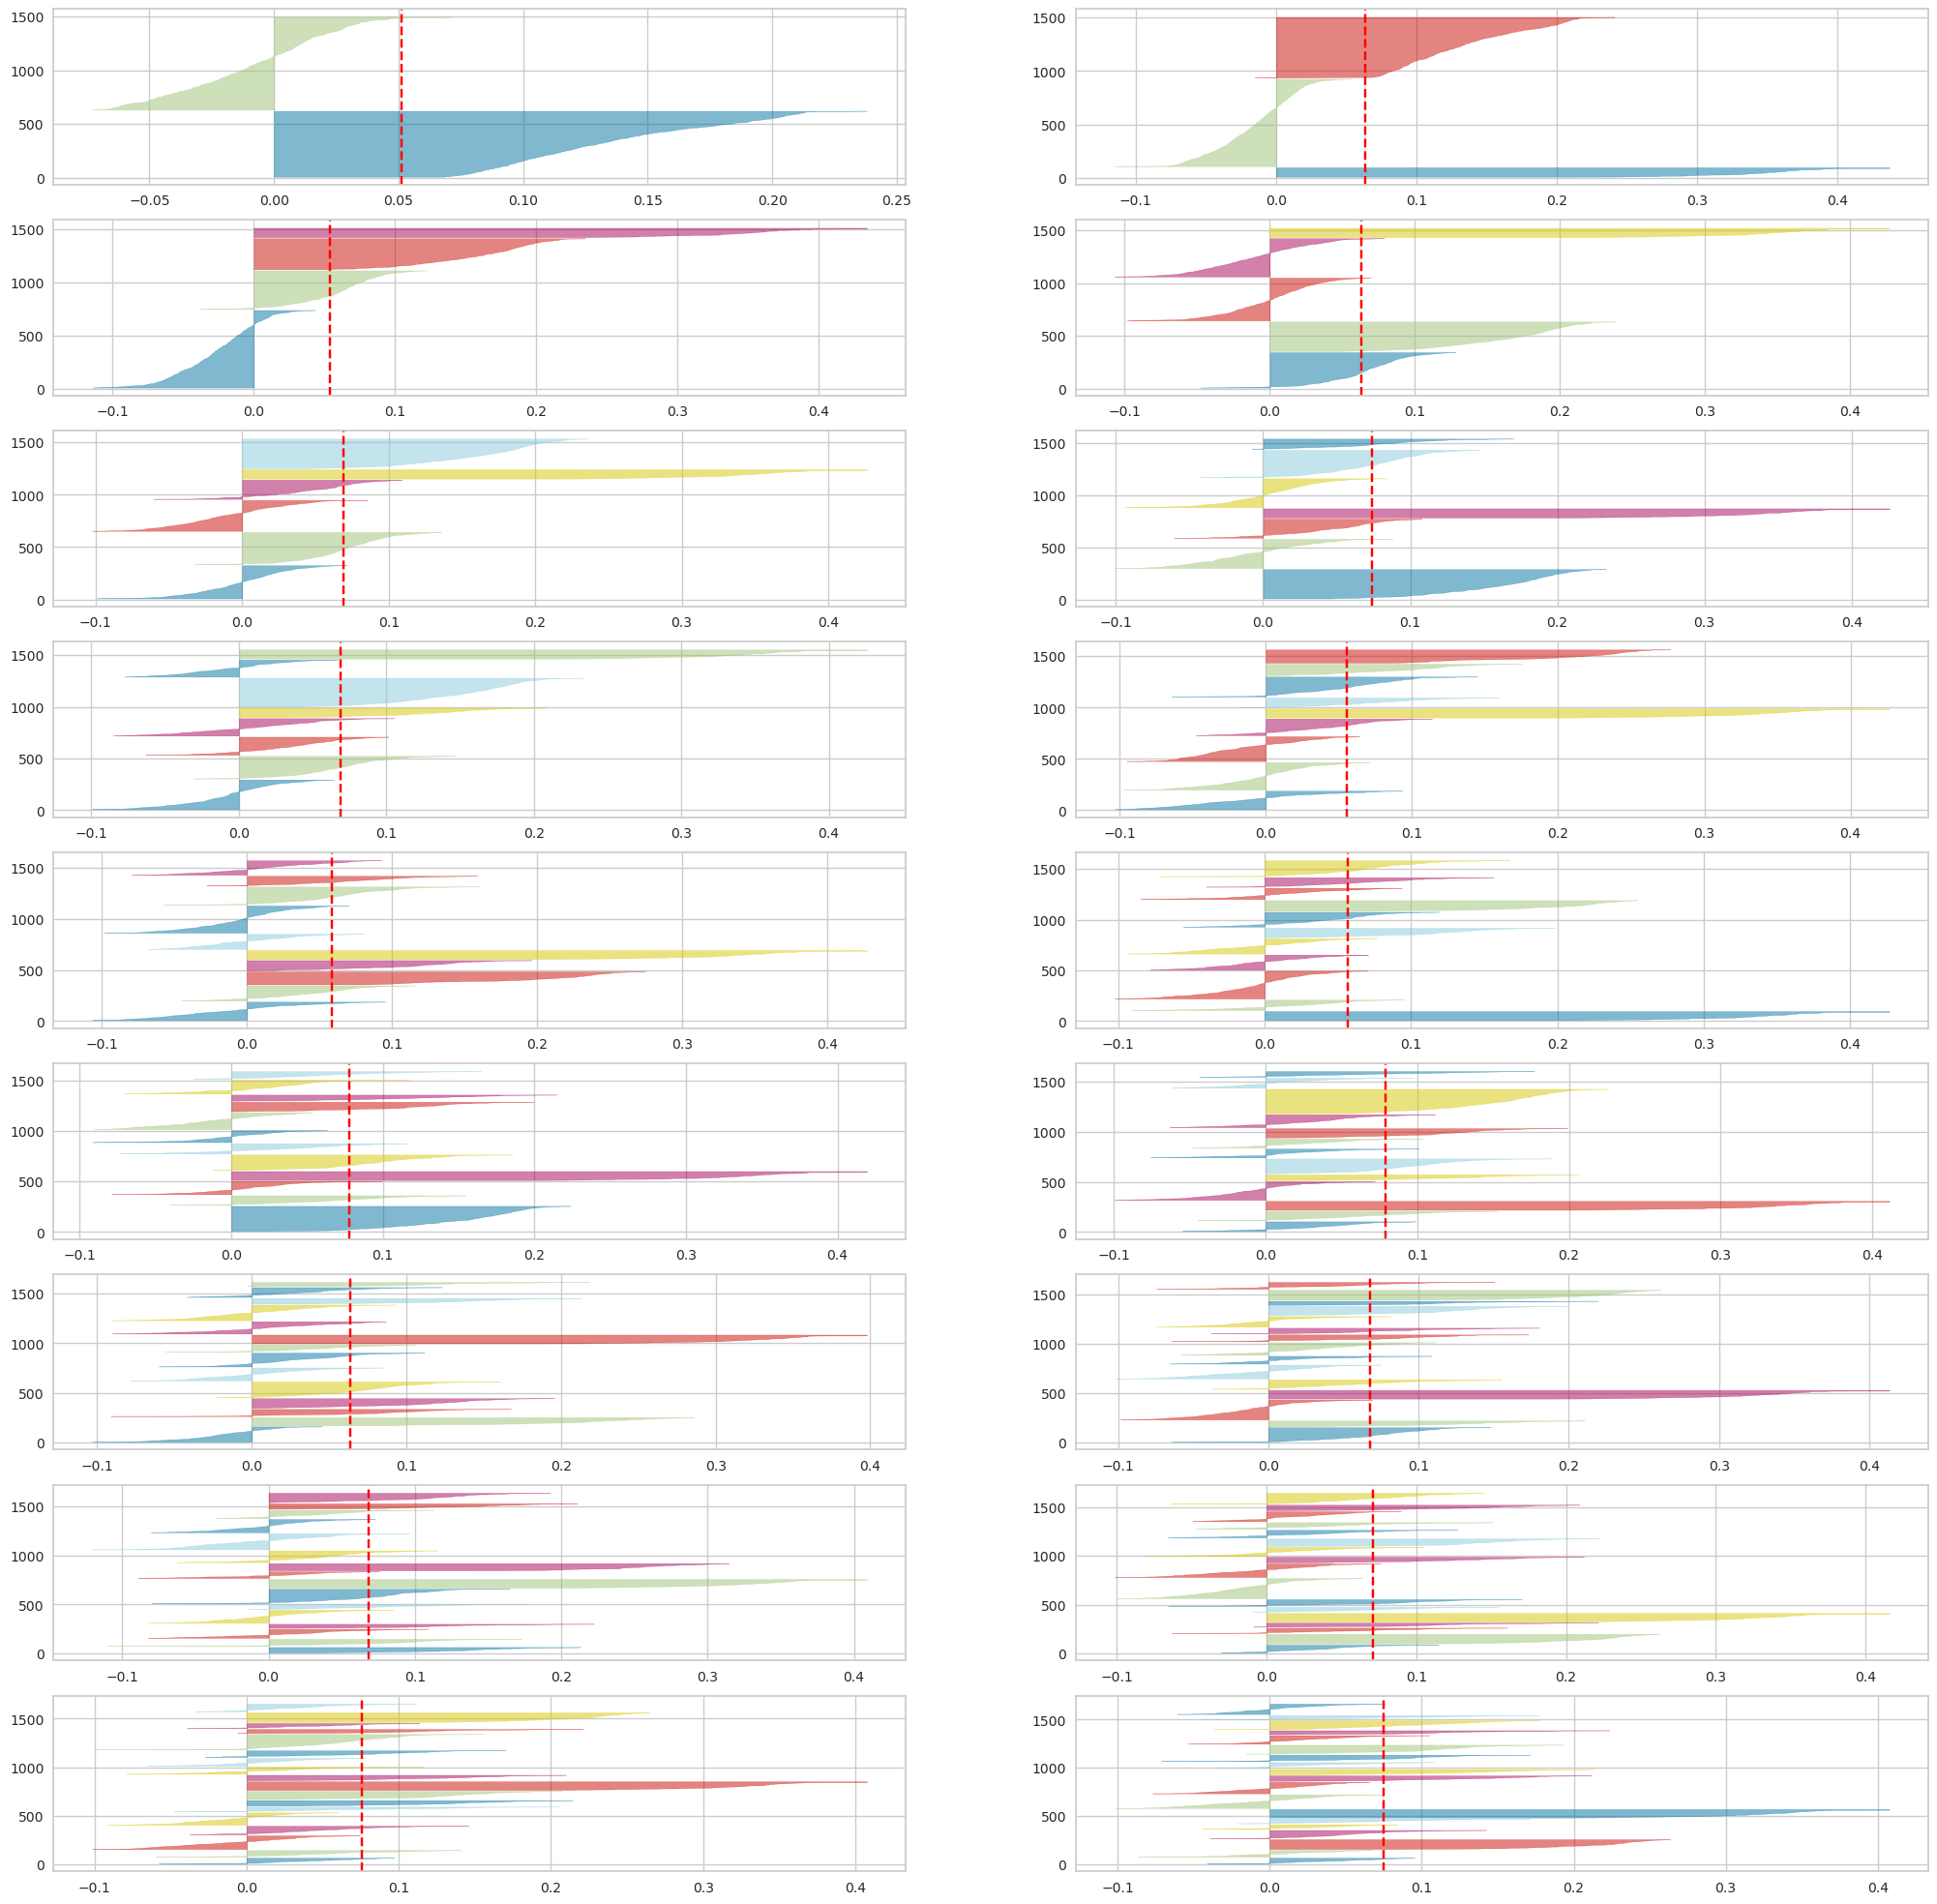

In [ ]:

# Create a figure and set of subplots with 10 rows and 2 columns.
fig, ax = plt.subplots(nrows=9, ncols=2, figsize=(25, 25))

# Iterate through the range of number of clusters (2 to 20)
for i in range(2, 20):
    # Create a KMeans instance with the number of clusters as i
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=11)
    # Divide i by 2 and get the quotient and remainder
    quo, rem = divmod(i, 2)

    # Create an instance of SilhouetteVisualizer with the KMeans instance and set the color to yellowbrick
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[quo-1][rem])
    # Fit the visualizer with the embeddings
    visualizer.fit(embeddings)

In [26]:
from sklearn.metrics import silhouette_score

# Create a list of possible numbers of clusters to try
num_clusters = list(range(2, 20))

# Calculate the silhouette scores for each number of clusters
silhouette_scores = []
for k in num_clusters:
    # run clustering for each k
    kmeans = KMeans(n_clusters=k,n_init=10)
    kmeans.fit(embeddings)
    labels = kmeans.predict(embeddings)
    #calculating the sihouetter score
    sil_score=silhouette_score(embeddings,labels)
    print("cluster:",k,  "score -> ",  sil_score)
    silhouette_scores.append(sil_score)
    

# displaying the optimum number of clusters
optimal_num_clusters = num_clusters[silhouette_scores.index(max(silhouette_scores))]
print("The highest s-score of the k-clusters: " , optimal_num_clusters)

#appending the result into the opmimum list
optimal_Ks.append(optimal_num_clusters)

cluster: 2 score ->  0.051307317
cluster: 3 score ->  0.05282659
cluster: 4 score ->  0.0539518
cluster: 5 score ->  0.063294105
cluster: 6 score ->  0.069335915
cluster: 7 score ->  0.07386023
cluster: 8 score ->  0.06827016
cluster: 9 score ->  0.07197566
cluster: 10 score ->  0.07010472
cluster: 11 score ->  0.056157388
cluster: 12 score ->  0.06305962
cluster: 13 score ->  0.059327014
cluster: 14 score ->  0.06517985
cluster: 15 score ->  0.06355617
cluster: 16 score ->  0.06649702
cluster: 17 score ->  0.068862215
cluster: 18 score ->  0.0748435
cluster: 19 score ->  0.075047
The highest s-score of the k-clusters:  19


_______________

### Davies Bouldin


In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Create a list of possible numbers of clusters to try
num_clusters = list(range(2, 21))

# Calculate the silhouette scores for each number of clusters
dav_scores = []
for k in num_clusters:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(embeddings)
    labels = kmeans.predict(embeddings)
    
    # calculating Davies score for each k
    dav_score=davies_bouldin_score(embeddings, labels)
    print("cluster:",k,  "value -> ",  dav_score)
    dav_scores.append(dav_score)
    

# displaying the optimum number of clusters
optimal_num_clusters = num_clusters[dav_scores.index(min(dav_scores))]
print("The optimum score of the k-clusters: " , optimal_num_clusters)

#appending the result into the opmimum list
optimal_Ks.append(optimal_num_clusters)

cluster: 2 value ->  3.901308281521465
cluster: 3 value ->  2.677461518196459
cluster: 4 value ->  3.273153688930295
cluster: 5 value ->  3.465672301202102
cluster: 6 value ->  3.3854897119468803
cluster: 7 value ->  3.262497590437999
cluster: 8 value ->  3.3201924598694457
cluster: 9 value ->  3.215273378136705
cluster: 10 value ->  3.176536798153111
cluster: 11 value ->  3.1820175668944586
cluster: 12 value ->  3.2966871598818375
cluster: 13 value ->  3.1432904133388173
cluster: 14 value ->  3.1967738195693296
cluster: 15 value ->  2.9881859066379857
cluster: 16 value ->  3.177090241732834
cluster: 17 value ->  3.0129582976486793
cluster: 18 value ->  3.067050453402277
cluster: 19 value ->  3.0286870179377523
cluster: 20 value ->  3.009820066940346
The optimum score of the k-clusters:  3


Text(0, 0.5, 'Davies Bouldin score')

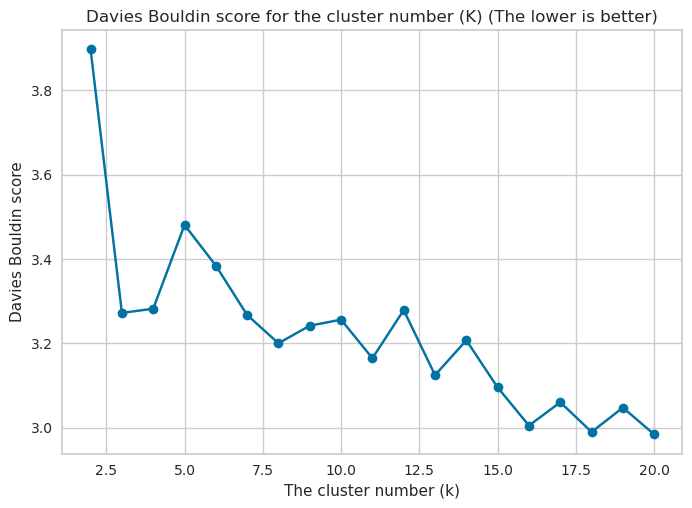

In [ ]:
# plotting Davies Bouldin score for K means
from sklearn.metrics import davies_bouldin_score

scores = []
for k in range(2,21):
    kmeans = KMeans(n_clusters=k)
    model = kmeans.fit_predict(embeddings)
    scores.append(davies_bouldin_score(embeddings, model))
    
plt.plot(list(range(2,21)), scores, marker='o', color='b')
plt.title('Davies Bouldin score for the cluster number (K) (The lower is better)')
plt.xlabel('The cluster number (k)')
plt.ylabel('Davies Bouldin score')

______________
### Calinski-Harabasz



In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score

# Create a list of possible numbers of clusters to try
num_clusters = list(range(2, 21))

# Calculate the silhouette scores for each number of clusters
cal_scores = []
for k in num_clusters:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(embeddings)
    labels = kmeans.predict(embeddings)
    
    # calculating Calinski index
    cal_score=calinski_harabasz_score(embeddings, labels)
    print("cluster:",k,  "value -> ",  cal_score)
    cal_scores.append(cal_score)
    

# displaying the optimum number of clusters
optimal_num_clusters = num_clusters[cal_scores.index(max(cal_scores))]
print("The optimum score of the k-clusters: " , optimal_num_clusters)

cluster: 2 value ->  90.82901889714947
cluster: 3 value ->  80.03306175482702
cluster: 4 value ->  75.21781108043757
cluster: 5 value ->  68.70591566078377
cluster: 6 value ->  61.67206273024255
cluster: 7 value ->  56.41954226835759
cluster: 8 value ->  51.87056856269302
cluster: 9 value ->  48.97970662510522
cluster: 10 value ->  46.171697424743094
cluster: 11 value ->  43.9620996051266
cluster: 12 value ->  42.175436474131104
cluster: 13 value ->  40.26370889286975
cluster: 14 value ->  38.808694408093935
cluster: 15 value ->  37.415281645256314
cluster: 16 value ->  36.07258118412822
cluster: 17 value ->  35.01423938471114
cluster: 18 value ->  33.73856108577289
cluster: 19 value ->  32.88815653074507
cluster: 20 value ->  32.059537052696655
The optimum score of the k-clusters:  2


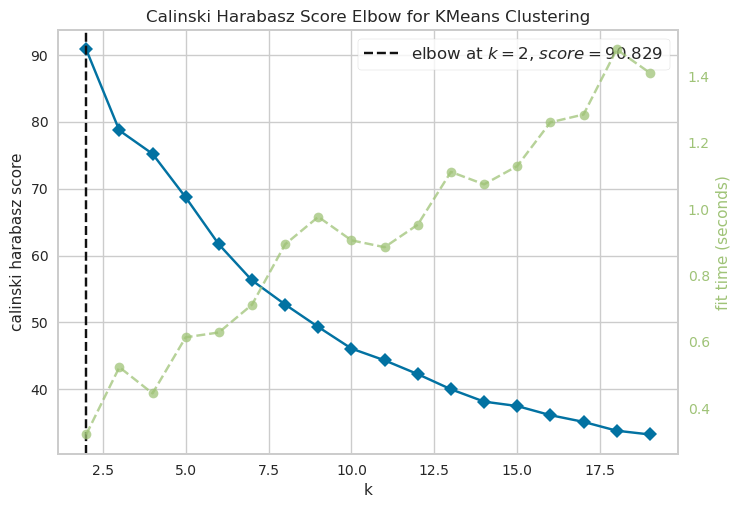

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [ ]:
# Calinski Harabasz Score for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,20),metric='calinski_harabasz')
visualizer.fit(embeddings)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

-----
### 5.4. X-means Algorithm


In [31]:
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

# Create an X-means object with the sample data
xmeans_instance = xmeans(embeddings, kmeans_plusplus_initializer(embeddings, 2).initialize())

# Perform the X-means algorithm
xmeans_instance.process()

# Get the optimal number of clusters
clusters = xmeans_instance.get_clusters()

# print the clusters
print('the identified optimum cluster ==> ',len(clusters))

#appending the result into the opmimum list
optimal_Ks.append(len(clusters))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
the identified optimum cluster ==>  9


In [32]:
# lets vote the median of the suggested clusters
int(np.median(optimal_Ks))

9

## Clustering the Data 


In [ ]:

true_k = int(np.median(optimal_Ks))
k_model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
k_model.fit(embeddings)

# the labels given by clusters
labels=k_model.labels_
labels

array([6, 6, 3, ..., 1, 8, 5], dtype=int32)

In [34]:
data.shape

(1476, 3)

In [35]:
# adding the labels to the our original dataset
data['labels'] = pd.Categorical(labels)

data.head()

Subject                                      Name  \
0    MATH                        Abstract Algebra I   
1    MATH                   Abstract Linear Algebra   
2    CHEM                   Accelerated Chemistry I   
3    CHEM               Accelerated Chemistry Lab I   
4      CS  Accelerated Fundamentals of Algorithms I   

                                         Description labels  
0  Isomorphism theorems for groups. Group actions...      6  
1  Rigorous proof-oriented course in linear algeb...      6  
2  Lectures and discussions. Beginning chemistry ...      3  
3  Companion laboratory course to CHEM 202. Compr...      3  
4  The first class in a sequence of two classes t...      6

In [36]:
# data.groupby(['labels','Subject']).size(): this groups the data by two columns 'labels' and 'Subject' and then it counts the number of occurances in each group.
# .unstack() : this unstacks the DataFrame, which means it pivots the dataframe from long format to wide format.
data_wide = data.groupby(['labels','Subject']).size().to_frame().unstack()
data_wide

0                                                                 \
Subject ANTH BADM CEE CHEM CHLH CLE  CS ECE ENGL FIN FSHN  IS KIN MATH  MUS   
labels                                                                        
0          0    0   0    0   24  75   0   0    0   0    3   0  12    0    0   
1         11    8   4    2    5   0   8  13   16   8    9  30   8   12    1   
2          0    0   0    0    0   0   0   1    0   0    0   0   0    0  101   
3          0    0   4   51    0   0   0   3    0   0   35   0   1    0    0   
4          5    2   1    4    7   0  11  14    9   0    4   1   4    6    0   
5          0   65   0    0    4   0   2   1    0  54    6  20   1    0    0   
6          0    2  46    1    0   0  65  68    0   4    0  18   1   55    2   
7          0    0   0    0    0   0   0   0    3   0    0   1   2    0    2   
8         36    0   1    0   16   0   1   0   34   0    0  25  27    0    1   

                                
Subject MUSC  PS PSYC RST THEA  
labels                          
0          0   0   10   1    0  
1          0   6   15   8    7  
2        136   0    0   0    0  
3          0   0    0   0    0  
4          0   4   10   5    2  
5          0   1    1  18    0  
6          0   0    0   0    2  
7          2   0    0   0   68  
8          0  44   38  20    1

In [37]:
embeddings.shape

(1476, 384)

In [38]:
#reduce the dimension of data into two and then plot it
from sklearn.manifold import TSNE
X_embedded_2d = TSNE(n_components=2).fit_transform(embeddings)

In [39]:
data

Subject                                               Name  \
0       MATH                                 Abstract Algebra I   
1       MATH                            Abstract Linear Algebra   
2       CHEM                            Accelerated Chemistry I   
3       CHEM                        Accelerated Chemistry Lab I   
4         CS           Accelerated Fundamentals of Algorithms I   
...      ...                                                ...   
1471    ENGL                                    Writing Studies   
1472    ENGL                               Writing Technologies   
1473    ENGL        Writing about Literature, Text, and Culture   
1474      IS                       Youth Services Librarianship   
1475    BADM  iVenture Accelerator Seminar I: Topics in Entr...   

                                            Description labels  
0     Isomorphism theorems for groups. Group actions...      6  
1     Rigorous proof-oriented course in linear algeb...      6  
2     Lectures and discussions. Beginning chemistry ...      3  
3     Companion laboratory course to CHEM 202. Compr...      3  
4     The first class in a sequence of two classes t...      6  
...                                                 ...    ...  
1471  Reviews theory and research on the social and ...      8  
1472  Examines the relationship of computer technolo...      8  
1473  Writing-intensive, variable-topic course desig...      1  
1474  Theory and techniques in planning, implementin...      8  
1475  Designed for students actively engaged in lear...      5  

[1476 rows x 4 columns]

In [40]:
import texthero as hero

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyterlab/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


DEPRECATION: https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.3.1/en_core_web_sm-2.3.1.tar.gz#egg=en_core_web_sm==2.3.1 contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 83.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for en_core_web_sm: filename=en_core_web_sm-2.3.1-py3-none-any.whl size=12047087 sha256=43b26c61c60633cadf44f49c29928065b0106f618db98cdc42cda2e2be3e69b8
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/b7/0d/f0/7ecae8427c515065d75410989e15e5785dd3975fe06e795cd9
Successfully built en_core_web_sm
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


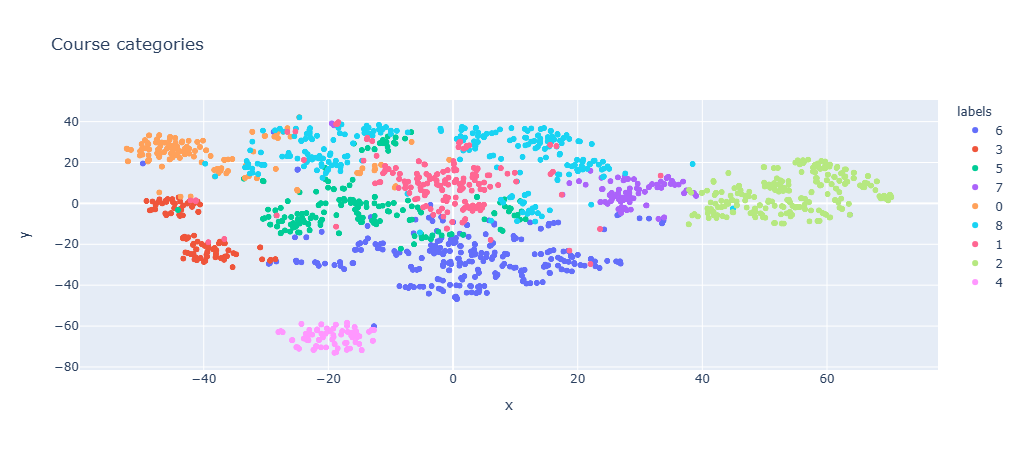

In [41]:
# coverting the vectors to array
data_hero = data.copy()
data_hero['vectors'] = np.array(embeddings).tolist() 

# using TSNE method to reduce the dimensions
data_hero['tsnemodel'] = hero.tsne(data_hero['vectors'])

# plot the data
hero.scatterplot(data_hero, col='tsnemodel'
                 , color='labels'
                 , title="Course categories"
                 , hover_data = ['Subject','Name'])

[Text(0.5, 1.0, 'Course data T-SNE projection')]

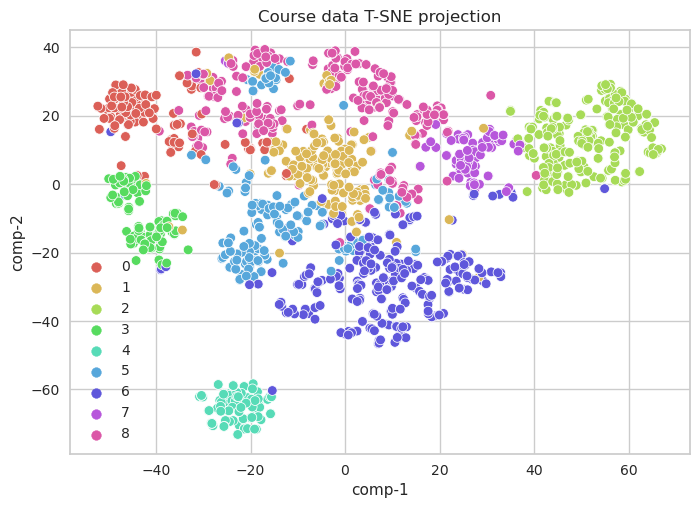

In [42]:
# Using sns package to plot the data
df_2d = pd.DataFrame()
df_2d["y"] = labels
df_2d["comp-1"] = X_embedded_2d[:,0]
df_2d["comp-2"] = X_embedded_2d[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df_2d.y.tolist(),
                palette=sns.color_palette("hls", true_k),
                data=df_2d).set(title="Course data T-SNE projection")

In [43]:
# reduce the dimention to 3 for 3d plotting
X_embedded_3d = TSNE(n_components=3).fit_transform(embeddings)

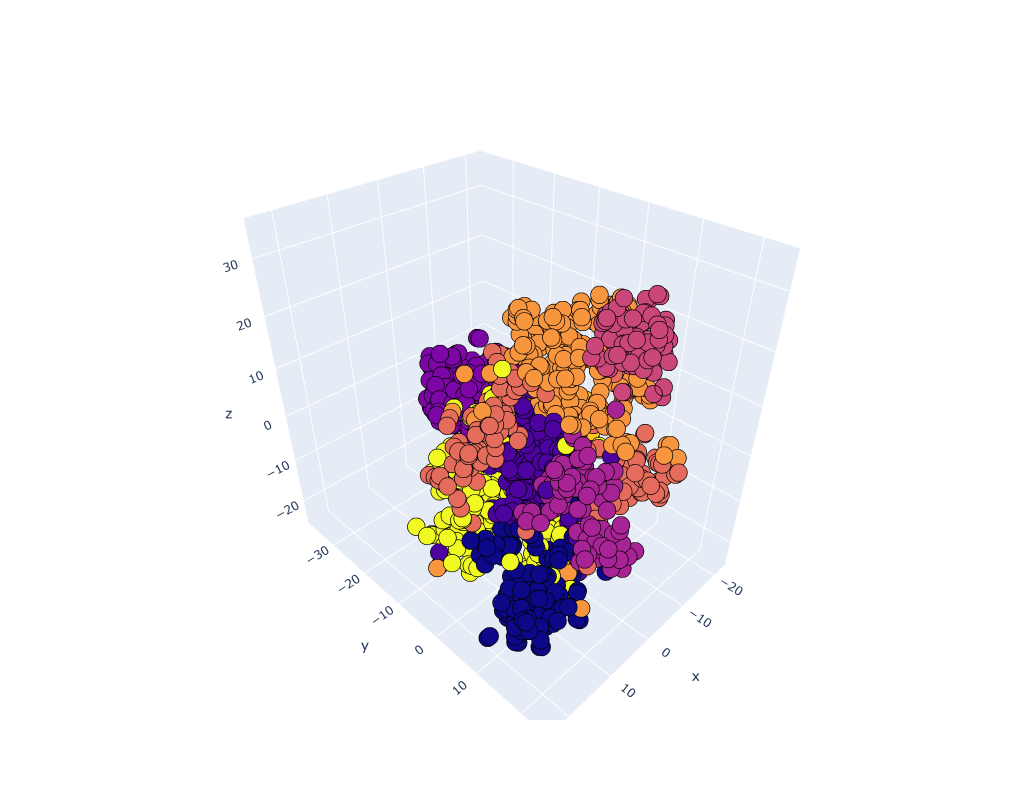

In [44]:
import plotly.graph_objects as go  #for 3D plot
txt=[["Subject: " + data['Subject'][i], "Lables: " + str(data['labels'][i])] for i in range(len(data))]  

trace = go.Scatter3d(x=X_embedded_3d[:,0], y=X_embedded_3d[:,1], z=X_embedded_3d[:,2], 
                     mode='markers',
                     text=txt,
                     marker=dict(color = labels, size= 10, line=dict(color= 'black',width = 10)))
layout = go.Layout(margin=dict(l=0,r=0),height = 800,width = 800)
trace = [trace]
fig = go.Figure(data = trace, layout = layout)
fig.show()

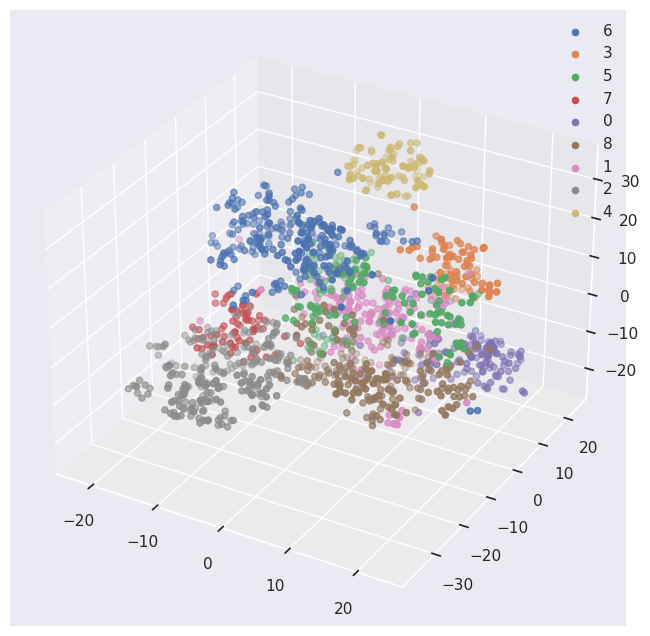

In [45]:
# plotting simple 3D plot

from mpl_toolkits.mplot3d import Axes3D

sns.set(style = "darkgrid")
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 8,8

#prepare a dataset for plotting
df_3d = pd.DataFrame()
df_3d["y"] = labels
df_3d["comp1"] = X_embedded_3d[:,0]
df_3d["comp2"] = X_embedded_3d[:,1]
df_3d["comp3"] = X_embedded_3d[:,2]


fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

# loop through labels of the clusters
for l in df_3d.y.unique():
    ax.scatter(df_3d.comp1[df_3d.y==l],df_3d.comp2[df_3d.y==l],df_3d.comp3[df_3d.y==l],label=l)
    
ax.legend()
plt.show()

## Creating Recommender 


In [46]:
import nmslib
model_index = nmslib.init(method='hnsw', space='cosinesimil')

In [47]:
model_index.addDataPointBatch(embeddings)

1476

In [48]:
model_index.createIndex({'post': 2})

In [49]:
def find_best_course(data, q_input):
    # Check if both inputs are not None
    if data is not None and q_input is not None:
        subset = data.copy()
        # Encode the q_input using the SBERT model
        query = model_SBERT.encode([q_input], convert_to_tensor=True)
        # Use the knnQuery function to find the 20 nearest neighbors to the encoded query
        ids, distances = model_index.knnQuery(query, k=20)
        
    # Initialize an empty list to store the best fits
    best_fits = []
    # Iterate through the returned ids and distances
    for i, j in zip(ids, distances):
        # Create a dictionary for each best fit containing information from the original data
        # Subject, Name, Description, cluster and distance returned by the knnQuery function
        best_fits.append({'Subject':subset.Subject.values[i]
                        , 'Name' : subset.Name.values[i]
                        , 'Description': subset.Description.values[i]
                        , 'Cluster': subset.labels.values[i]
                        , 'Distance': j
                       })
    return pd.DataFrame(best_fits)

In [ ]:
most_similar=find_best_course(data, "exploring computer and technology cultures")

# extract the most similar cluster
most_similar[most_similar['Cluster']==int(most_similar['Cluster'].mode())]

Subject                                            Name  \
0       IS                           Computers and Culture   
1       IS        Race, Gender, and Information Technology   
3       IS                        Social Aspects Info Tech   
4       IS   Entrepreneurial Information Technology Design   
5       IS                        Reading and Writing Data   
6       IS  History and Foundations of Information Science   
10    ENGL                            Writing Technologies   
12     RST     Technology in Recreation, Sport and Tourism   
14      IS                      Topics in Info Foundations   
15      IS              Social History of Games and Gaming   

                                          Description  Cluster  Distance  
0   This course explores cultural ideas about comp...        8  0.298154  
1   In this course we will critically examine the ...        8  0.443516  
3   Explores the way in which information technolo...        8  0.489111  
4   Introduces students to a range of rapid protot...        8  0.489189  
5   Explores how we tell stories and make argument...        8  0.505129  
6   Provides an introduction to the historical fou...        8  0.506650  
10  Examines the relationship of computer technolo...        8  0.523263  
12  An 8-week online class that will assist studen...        8  0.548529  
14  Directed and supervised investigation of selec...        8  0.551734  
15  A survey of the history of gaming from the anc...        8  0.556902

In [51]:
df2 = pd.read_csv('SN_IBM_course_dataset.csv')

# combining the two description columns
df2["Description"] = df2["short_description"] + ' ' + df2["long_description"]
df2 = df2[["topic","name","Description"]]

# rename the column for consitency
df2.rename(columns={"topic": "Subject","name":"Name"}, inplace=True)
df2.head(10)

Subject                                               Name  \
0                    Linux                                      Linux for All   
1           Text Analytics  Classify recipe text to cuisine using NLP and ...   
2  Artificial Intelligence  Marketing. Data Preparation, Basic Statistical...   
3         Machine Learning  Robots are coming! Build IoT apps with Watson,...   
4            Deep Learning  Build an Image Style Transfer Tool using Cycle...   
5                 Big Data                                 MapReduce and YARN   
6               Containers  Deploy a Computer Vision App in a Serverless E...   
7             Open Liberty  Streaming updates from a MicroProfile Reactive...   
8             Data Science  Credit Card Fraud Detection using Scikit-Learn...   
9              Open Source   Build Machine Learning Applications Using Gradio   

                                         Description  
0  Linux for All this course enables the new user...  
1  Have you ever wondered why certain foods taste...  
2  This lab is dedicated to loading, pre-preparat...  
3  Learn how to program a simple robot (TJBot) to...  
4  In this guided project, we will teach you to b...  
5  String together your understanding of Yet Anot...  
6  Learn how to make your object detection applic...  
7  Learn how to stream updates from a MicroProfil...  
8  Snap ML is a high-performance IBM library for ...  
9  Are you a Machine Learning practitioner who ha...

In [52]:
# data preparation
df2 = pd.read_csv('SN_IBM_course_dataset.csv')

# combining the two description columns
df2["Description"] = df2["short_description"] + ' ' + df2["long_description"]
df2 = df2[["topic","name","Description"]]

# rename the column for consitency
df2.rename(columns={"topic": "Subject","name":"Name"}, inplace=True)
df2.head(2)


Subject                                               Name  \
0           Linux                                      Linux for All   
1  Text Analytics  Classify recipe text to cuisine using NLP and ...   

                                         Description  
0  Linux for All this course enables the new user...  
1  Have you ever wondered why certain foods taste...

In [53]:
text = df2['Description']

# removing null values
text = text[~pd.isnull(text)] #removing missing values

# preprocessing
text=text.tolist()
text[:3]

['Linux for All this course enables the new users to start with shall commands to play with world most popular OS. About this CourseThis course is the starter kit for newcomers keen to learn the Linux\xa0 \xa0 .Course SyllabusAfter completing this course you will be able to understands the basic Linux commands:Intro to Linux CommandsWhat is LinuxList of Linux distrosUseful Linux CommandsBasic System commandsManaging filesCreate users and groupGeneral InformationThis is your place to add any additional information about your course. Feel free to mention the assessment style, a recommended timeline of events, or any other important information that a learner should know.Recommended Skills Prior to Taking this CourseBasic computer knowledge.',
 "Have you ever wondered why certain foods taste the way they do? Well, in this project, we will use NLP (Natural Language Processing) to determine the country of origin of recipes using the ingredients.\r\n\r\nThis project will introduce you to NLP

In [54]:
 df2=df2[~pd.isnull( df2['Description'])]

In [55]:
stemmer = PorterStemmer()
text_stem = [stemmer.stem(t) for t in text]
# Import nltk, and WordNetLemmatizer

In [56]:
lem = nltk.stem.wordnet.WordNetLemmatizer()
text_lem = [lem.lemmatize(t) for t in text_stem]
text_lem[:3]

['linux for all this course enables the new users to start with shall commands to play with world most popular os. about this coursethis course is the starter kit for newcomers keen to learn the linux\xa0 \xa0 .course syllabusafter completing this course you will be able to understands the basic linux commands:intro to linux commandswhat is linuxlist of linux distrosuseful linux commandsbasic system commandsmanaging filescreate users and groupgeneral informationthis is your place to add any additional information about your course. feel free to mention the assessment style, a recommended timeline of events, or any other important information that a learner should know.recommended skills prior to taking this coursebasic computer knowledge.',
 "have you ever wondered why certain foods taste the way they do? well, in this project, we will use nlp (natural language processing) to determine the country of origin of recipes using the ingredients.\r\n\r\nthis project will introduce you to nlp

In [57]:
embeddings = model_SBERT.encode(text_lem, convert_to_numpy=True,show_progress_bar=True,batch_size=100) # By default, convert_to_numpy = True
embeddings.shape

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(395, 384)

In [58]:
df2.shape

(395, 3)

In [59]:
kmeans = KMeans(n_clusters=18)
kmeans.fit(embeddings)
df2['labels'] = pd.Categorical(kmeans.labels_)

In [60]:
df2['labels'] = pd.Categorical(kmeans.labels_)


In [61]:
kmeans.labels_.shape

(395,)

In [62]:
model_index = nmslib.init(method='hnsw', space='cosinesimil')
model_index.addDataPointBatch(embeddings)
model_index.createIndex({'post': 2})